In [28]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

In [29]:
X,y = make_circles(n_samples=1000, noise = 0.03, random_state=42)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (1000, 2)
Shape of y: (1000,)


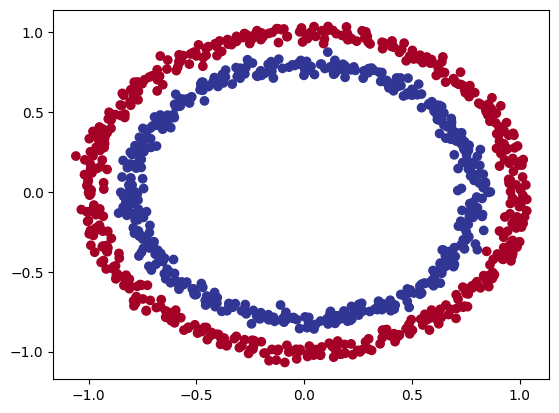

In [30]:
plt.scatter(X[:,0], X[:,1], c=y, cmap = 'RdYlBu')

In [31]:
X,y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)
print("type of x:",type(X))
print("type of y:",type(y))

type of x: <class 'torch.Tensor'>
type of y: <class 'torch.Tensor'>


In [32]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


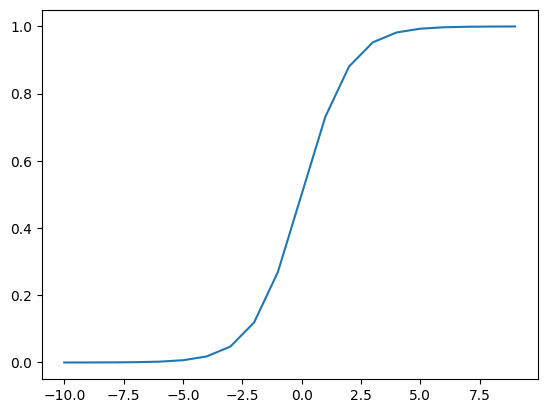

In [33]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

demo_x= range(-10, 10)
demo_y = [sigmoid(val) for val in demo_x]

plt.plot(demo_x, demo_y)


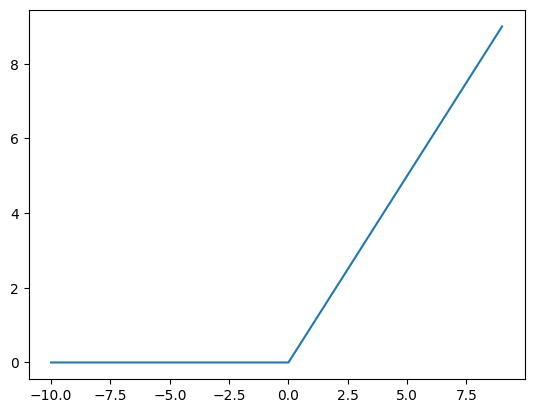

In [34]:
def relu(x):
    if x<=0:
        return 0
    else:
        return x


demo_x = range(-10, 10)
demo_y = [relu(val) for val in demo_x]

plt.plot(demo_x, demo_y)

In [35]:
class CircleClassifier(nn.Module):
    def __init__(self ,input_features,output_features, hidden_features=10):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_features, out_features=hidden_features)
        self.layer2 = nn.Linear(in_features=hidden_features,
                               out_features=hidden_features)
        self.layer3 = nn.Linear(in_features=hidden_features,
                               out_features=output_features)
        self.relu = nn.ReLU()

    def forward(self, x:torch.Tensor)->torch.Tensor:
        x=self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))

        return self.layer3(x)

In [36]:
model_1 = CircleClassifier(input_features=2, output_features=1)
model_1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.1163, -0.4394],
                      [ 0.4613, -0.1690],
                      [-0.6382,  0.4201],
                      [-0.6717,  0.0954],
                      [ 0.5839,  0.3425],
                      [ 0.4498, -0.3661],
                      [-0.0357,  0.4766],
                      [-0.1552, -0.0273],
                      [ 0.6265,  0.5353],
                      [-0.4814,  0.2854]])),
             ('layer1.bias',
              tensor([-0.6399,  0.2624, -0.3315,  0.0058,  0.3893,  0.3197, -0.5001,  0.0421,
                      -0.2834, -0.5444])),
             ('layer2.weight',
              tensor([[ 0.1399,  0.1465, -0.2126,  0.3123, -0.0940,  0.0667, -0.2549,  0.2140,
                       -0.1382,  0.1826],
                      [-0.1974, -0.0544,  0.2283, -0.0584, -0.0488, -0.2146,  0.2908, -0.2826,
                       -0.0717, -0.1093],
                      [ 0.1719,  0.2496,  0.0936, -0.1036, -0.1835, -0.1240

In [37]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [38]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device ='cpu'
print(device)

cpu


In [39]:
from tqdm import tqdm 
epochs = 1000
model_1.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
trainLossList = []
testLossList = []
for epoch in range(epochs):
    #training
    model_1.train()

    #forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    #compute loss
    loss = loss_fn(y_logits, y_train)
    
    #zero grad optimizer
    optimizer.zero_grad()

    #back propagate
    loss.backward()

    #step the optimizer
    optimizer.step()

    #testing
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss  = loss_fn(test_logits, test_pred)

    if(epoch%100==0):
        print(f"epoch:{epoch}|train loss:{loss:.5f}|test loss:{test_loss:.5f}")
    
    trainLossList.append(loss.cpu().detach().numpy())
    testLossList.append(test_loss.cpu().detach().numpy())

epoch:0|train loss:0.69359|test loss:0.63263
epoch:100|train loss:0.68928|test loss:0.67360
epoch:200|train loss:0.68674|test loss:0.66840
epoch:300|train loss:0.68310|test loss:0.66048
epoch:400|train loss:0.67773|test loss:0.64875
epoch:500|train loss:0.66938|test loss:0.63218
epoch:600|train loss:0.65627|test loss:0.61277
epoch:700|train loss:0.63158|test loss:0.60078
epoch:800|train loss:0.58063|test loss:0.58457
epoch:900|train loss:0.49353|test loss:0.51136


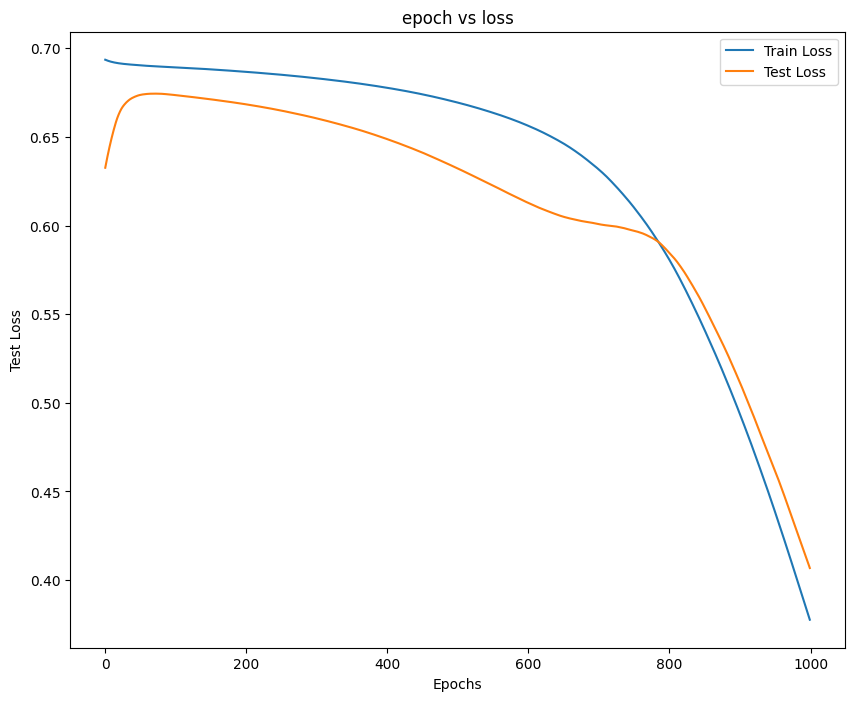

In [40]:
plt.figure(figsize=(10,8))
plt.plot(trainLossList, label="Train Loss")
plt.plot(testLossList, label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('epoch vs loss')
plt.legend()